# Lab 4: Comparison of Classifiers

### Student: Garret Molloy
### Student Id: 9012906

This notebook demonstrates how to choose the best out of a few alternative classification models by applying cross-validation and comparing the accuracy of prediction, the F1-scores and the ROC curves of the classification models.

Here we use a _modified version_ of the __seeds data set__ (see https://archive.ics.uci.edu/ml/datasets/seeds), which is one of the public UCI data sets. Each example is a seed described by a few numerical attributes. The target variable for classification (in this example) is the type of the seed, which can be either 1 or 0. Class 1 are the seeds of a particular type that, we can assume, is important to learn to predict correctly, while class 0 are all other seeds.

In this example, we use 5-fold cross-validation. Empirical evidence suggests that 10 folds are probably the best choice for cross-validation, i.e. 10-fold cross-validation. However, since this data set is relatively small, and 1/10 of it is only 21 examples, it is sensible to use larger folds for testing. Thus, we demonstrate the comparison of classifiers with 5-fold cross-validation.

The code in this notebook was originally inspired by the example at https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html.

## A. Preparation

### Import Python modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.fixes import signature

from scipy import interp

### Import evaluation and plotting functions

In [59]:
%run ./Lab4_Functions.ipynb

# I edited this set of methods by adding a Class to return the various scores.
# Small saving in code.

### Load and prepare the dataset for training and evaluating a classifier
Feel free to apply any other pre-processing technique at this point.

In [3]:
lab4_df = pd.read_csv("./loans_et4.csv")
lab4_df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.797917,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


In [4]:
lab4_df.shape

(480, 12)

In [5]:
# target attribute
target = lab4_df['Loan_Status']

# predictor attributes
predictors = lab4_df.drop('Loan_Status', axis=1).values

# scale all predictor values to the range [0, 1]
# note the target attribute 'type' is already binary
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

### Prepare an array of 100 equally spaced false-positive-rate values between 0 and 1
To be used as an x-axis in ROC curve plots.

In [6]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [7]:
mean_fpr

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

## B. Evaluation and Comparison of Classifiers

### Train a Probablistic SVM Classifier

In [8]:
# Create an SVM classifier object as a probabilistic classifier with default parameters
SVM_classifier = svm.SVC(probability=True, gamma='auto')

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
SVM_scores = evaluate_classifier(folds=5, 
                                p=predictors, t=target, 
                                classifier=SVM_classifier, 
                                mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

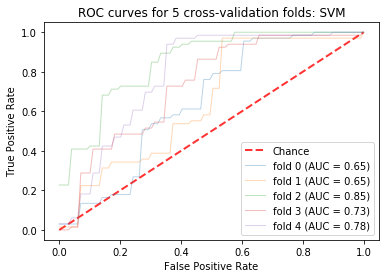

In [9]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, SVM_scores, 'SVM')

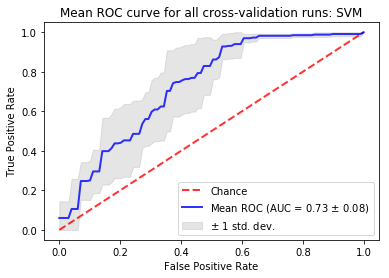

In [10]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, SVM_scores, 'SVM')

### Train a Naive Bayes Classifier

In [11]:
# Create a Naive Bayes classifier object with default parameters (note: Naive Bayes is a probabilistic classifier by default)
NB_classifier = GaussianNB()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
NB_scores = evaluate_classifier(folds=5, 
                                p=predictors, t=target, 
                                classifier=NB_classifier, 
                                mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

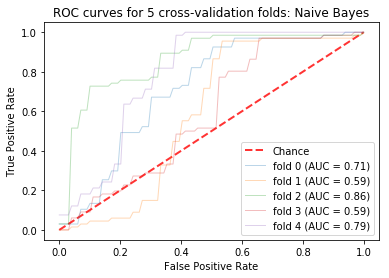

In [12]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, NB_scores, 'Naive Bayes')

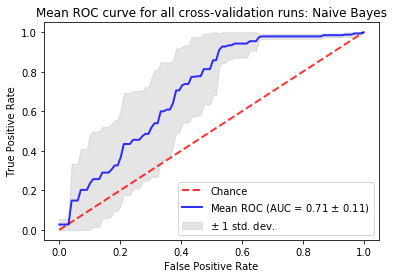

In [13]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, NB_scores, 'Naive Bayes')

### Train a NN Classifier

In [14]:
# Create a NN classifier object with default parameters 
from sklearn.neural_network import MLPClassifier

NN_classifier = MLPClassifier(alpha=1, random_state=0, max_iter=500, solver='sgd', 
                              learning_rate='invscaling', momentum=.9,
                              nesterovs_momentum=False, learning_rate_init=0.2)

# Train and evaluate the classifier by applying 10-fold cross validation.
# We use 5 folds only, because the data set is rather small.
NN_scores = evaluate_classifier(folds=5, 
                                p=predictors, t=target, 
                                classifier=NN_classifier, 
                                mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold

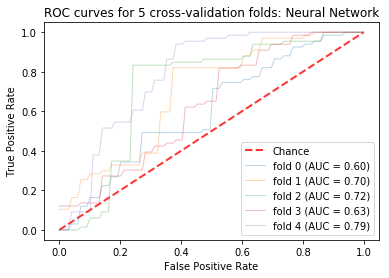

In [15]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, NN_scores, 'Neural Network')

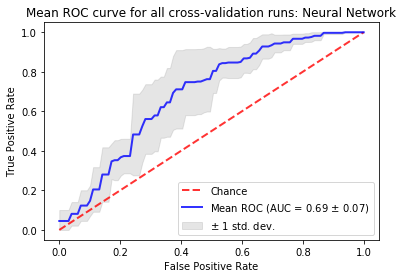

In [16]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, NN_scores, 'Neural Network')

## Task 2.1
2.1 Modify the code in both Lab 4 - Comparison of Classifiers.ipynb and Lab4_Functions.ipynb to __boxplot precision and recall__ for the classifiers trained with loans_et4.csv. 

In [24]:
SVM_scores.precision_scores.shape

(5,)

In [26]:
# Compare the statistics of the accuracies across all cross-validation folds
precisions_df = pd.DataFrame(data={'SVM' : SVM_scores.precision_scores, 
                                   'Naive Bayes' : NB_scores.precision_scores, 
                                   'Neural Network' : NN_scores.precision_scores})

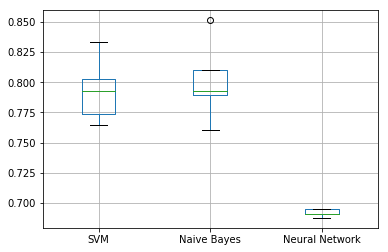

In [27]:
precisions_df.boxplot()

In [28]:
# Compare the statistics of the accuracies across all cross-validation folds
recall_df = pd.DataFrame(data={'SVM' : SVM_scores.recall_scores, 
                                   'Naive Bayes' : NB_scores.recall_scores, 
                                   'Neural Network' : NN_scores.recall_scores})

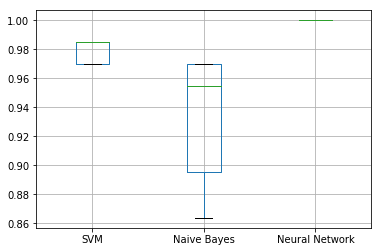

In [29]:
recall_df.boxplot()

## Task 2.2 
Plot __precision-recall curves__ for each of the trained classifiers as well. These should be the mean curves over all cross-validation runs. Update your conclusions from Task 1 after evaluating precision and recall.

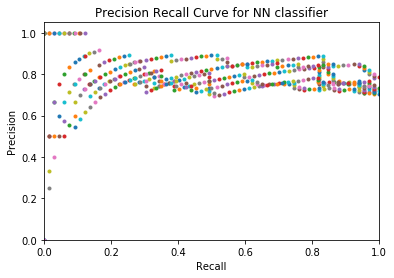

In [60]:
# Can't get this working
plot_precision_recall_curve(mean_fpr, NN_scores, 'NN')

In [47]:
NN_scores.precisions

(458,)

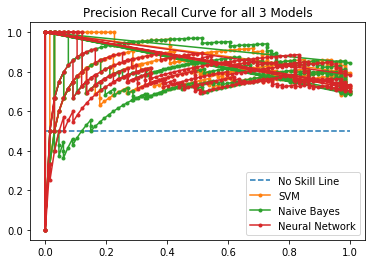

In [46]:
SVM_precision = SVM_scores.precisions
SVM_recall = SVM_scores.recalls
NB_precision = NB_scores.precisions
NB_recall = NB_scores.recalls
NN_precision = NN_scores.precisions
NN_recall = NN_scores.recalls

# print("PRT")
# print(precision)
# print(recall)
# print(thresholds)

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--', label="No Skill Line")
# plot the roc curve for the model
plt.plot(SVM_recall, SVM_precision, label="SVM")
plt.plot(NB_recall, NB_precision, marker='.', label="Naive Bayes")
plt.plot(NN_recall, NN_precision, marker='.', label="Neural Network")
# show the plot
plt.title("Precision Recall Curve for all 3 Models")
plt.legend()
plt.show()

In [ ]:
# EXAMPLE WORKING CODE: PRECISION RECALL CURVE 
# Sampel Data
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainX, trainy)
# predict probabilities
probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = model.predict(testX)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testy, probs)
# calculate F1 score
f1 = f1_score(testy, yhat)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(testy, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

print(precision)
print(recall)

### Compare All Trained Classifiers

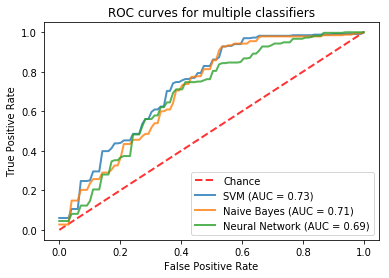

In [34]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(SVM_scores.tprs, axis=0), np.mean(NB_scores.tprs, axis=0), 
                                        np.mean(NN_scores.tprs, axis=0))), 
                              np.array([np.mean(SVM_scores.aucs), np.mean(NB_scores.aucs), np.mean(NN_scores.aucs)]), 
                              np.array(['SVM', 'Naive Bayes', 'Neural Network']))

In [35]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'SVM' : SVM_scores.accuracies, 'Naive Bayes' : NB_scores.accuracies, 'Neural Network' : NN_scores.accuracies})

In [36]:
accuracies_df.describe()

,SVM,Naive Bayes,Neural Network
count,5.000000,5.000000,5.000000
mean,0.808403,0.791670,0.691683
std,0.029567,0.053465,0.003082
min,0.778947,0.715789,0.687500
25%,0.783505,0.762887,0.690722
50%,0.812500,0.804124,0.690722
75%,0.814433,0.822917,0.694737
max,0.852632,0.852632,0.694737


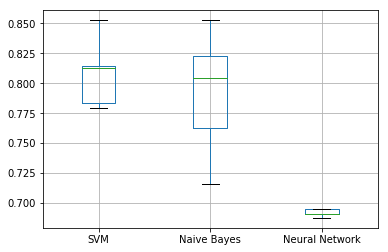

In [37]:
accuracies_df.boxplot()

In [38]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : SVM_scores.f1_scores, 'Naive Bayes' : NB_scores.f1_scores, 'Neural Network' : NN_scores.f1_scores})

In [39]:
f1_scores_df.describe()

,SVM,Naive Bayes,Neural Network
count,5.000000,5.000000,5.000000
mean,0.876278,0.860583,0.817743
std,0.017193,0.036598,0.002155
min,0.860927,0.808511,0.814815
25%,0.860927,0.839161,0.817073
50%,0.878378,0.872483,0.817073
75%,0.878378,0.882759,0.819876
max,0.902778,0.900000,0.819876


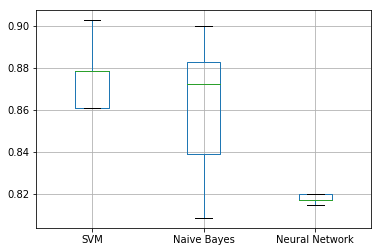

In [40]:
f1_scores_df.boxplot()

## Task 3.1 (CS5062)

__Pick a __winner among the classifiers__ you have trained with loans_et4.csv. Assume that it is important to __minimise the false positives__ (i.e., Loan_Status predicted to be 1 wrongly). 

## Task 3.2 (CS5062)
Look up the training parameters for this classifier on the scikit-learn website. For example, SVM has more than 10 parameters (see https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). 

__Experiment with the parameters and see if you can improve the model in terms of accuracy, precision, recall and AUC.__ 

You do not have to build a better model but to show that you have explored some of its training parameters. Summarise your experience with exploring the parameters (max 150 words in a markdown cell).

#### Conclusion

In this example, both the SVM and the Naive Bayes classifiers have mean accuracy approximately 88%, which is quite high. The ROC curves do not suggest a clear winner, although it can be noted that Naive Bayes can achieve TPR above 80% for a lower FPR than SVM. On the other hand, the accuracy of the five folds of Naive Bayes show higher variance than the accuracy of the five folds of SVM, and low variance is desirable. Still, the lowest accuracy of Naive Bayes is above 75% which is not bad. Similar observation can be made about the F1 score. Naive Bayes has a higher mean F1 score but also higher variance. Since both SVM and Naive Bayes have high mean accuracy, high mean F1 score and a very similar AUC, while SVM appears to have visibly lower variance than Naive Bayes, we can conclude that perhaps SVM is a safer choice for a best model. 

It will be interesting to plot precision and recall for a more detailed comparison. Since the two classes are not well balanced (1/3 of the examples are in class 1), a precision-recall curve a more detailed study of the precision and recall can provide better information than the ROC curves for picking the best model.

## C. FInal Model

Assuming SVM was chosen, now we can train a final (to be potentially deployed) SVM model with the whole dataset:

In [ ]:
model = NB_classifier.fit(predictors, target)

Use the model to predict the type of three new seeds:

In [ ]:
new_seeds = np.array([[0.4,0.5,0.6,0.5,0.5,0.2,0.3], [0.0,1.0,0.0,1.0,0.5,0.5,0.2], [0.2,0.2,0.2,1.0,0.2,0.2,0.2]])

In [ ]:
# Probabilistic prediction
np.round(model.predict_proba(new_seeds), 2)
# Note: 
#   - the first column are the probabilities for the three new seeds to belong to class 0
#   - the second column are the probabilities for the three new seeds to belong to class 1

In [ ]:
# Exact prediction
model.predict(new_seeds)